In [1]:
import pandas as pd
import numpy as np

from scipy.stats import skew

%matplotlib inline

Import Data
======

In [2]:
house_train = pd.read_csv("/home/aeb/Documents/mlproj/mlproj/train.csv")
house_test = pd.read_csv("/home/aeb/Documents/mlproj/mlproj/test.csv")
house_all = pd.concat((house_train, house_test))

Data Preprocessing and Cleaning
===============================

Filling in Missing Values
-----------------------------

Figure out which columns are numerical and which are categorical

In [3]:
numerical_features = house_all.select_dtypes(include=["float", "int", "bool"]).columns.values
categorical_features = house_all.select_dtypes(include=["object"]).columns.values

In [4]:
print(numerical_features, "\n\n", categorical_features)

['1stFlrSF' '2ndFlrSF' '3SsnPorch' 'BedroomAbvGr' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtFullBath' 'BsmtHalfBath' 'BsmtUnfSF' 'EnclosedPorch' 'Fireplaces'
 'FullBath' 'GarageArea' 'GarageCars' 'GarageYrBlt' 'GrLivArea' 'HalfBath'
 'Id' 'KitchenAbvGr' 'LotArea' 'LotFrontage' 'LowQualFinSF' 'MSSubClass'
 'MasVnrArea' 'MiscVal' 'MoSold' 'OpenPorchSF' 'OverallCond' 'OverallQual'
 'PoolArea' 'SalePrice' 'ScreenPorch' 'TotRmsAbvGrd' 'TotalBsmtSF'
 'WoodDeckSF' 'YearBuilt' 'YearRemodAdd' 'YrSold'] 

 ['Alley' 'BldgType' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'BsmtQual' 'CentralAir' 'Condition1' 'Condition2' 'Electrical' 'ExterCond'
 'ExterQual' 'Exterior1st' 'Exterior2nd' 'Fence' 'FireplaceQu' 'Foundation'
 'Functional' 'GarageCond' 'GarageFinish' 'GarageQual' 'GarageType'
 'Heating' 'HeatingQC' 'HouseStyle' 'KitchenQual' 'LandContour' 'LandSlope'
 'LotConfig' 'LotShape' 'MSZoning' 'MasVnrType' 'MiscFeature'
 'Neighborhood' 'PavedDrive' 'PoolQC' 'RoofMatl' 'RoofStyle'
 'SaleConditi

Fill in some missing values (mostly categorical), modified from technique described here:

https://www.kaggle.com/klyusba/lasso-model-for-regression-problem 

In [5]:
house_all.loc[house_all.Alley.isnull(), 'Alley'] = 'NoAlley'
house_all.loc[house_all.MasVnrType.isnull(), 'MasVnrType'] = 'None' # no good
house_all.loc[house_all.MasVnrType == 'None', 'MasVnrArea'] = 0
house_all.loc[house_all.BsmtQual.isnull(), 'BsmtQual'] = 'NoBsmt'
house_all.loc[house_all.BsmtCond.isnull(), 'BsmtCond'] = 'NoBsmt'
house_all.loc[house_all.BsmtExposure.isnull(), 'BsmtExposure'] = 'NoBsmt'
house_all.loc[house_all.BsmtFinType1.isnull(), 'BsmtFinType1'] = 'NoBsmt'
house_all.loc[house_all.BsmtFinType2.isnull(), 'BsmtFinType2'] = 'NoBsmt'
house_all.loc[house_all.BsmtFinType1=='NoBsmt', 'BsmtFinSF1'] = 0
house_all.loc[house_all.BsmtFinType2=='NoBsmt', 'BsmtFinSF2'] = 0
house_all.loc[house_all.BsmtFinSF1.isnull(), 'BsmtFinSF1'] = house_all.BsmtFinSF1.median()
house_all.loc[house_all.BsmtQual=='NoBsmt', 'BsmtUnfSF'] = 0
house_all.loc[house_all.BsmtUnfSF.isnull(), 'BsmtUnfSF'] = house_all.BsmtUnfSF.median()
house_all.loc[house_all.BsmtQual=='NoBsmt', 'TotalBsmtSF'] = 0
house_all.loc[house_all.FireplaceQu.isnull(), 'FireplaceQu'] = 'NoFireplace'
house_all.loc[house_all.GarageType.isnull(), 'GarageType'] = 'NoGarage'
house_all.loc[house_all.GarageFinish.isnull(), 'GarageFinish'] = 'NoGarage'
house_all.loc[house_all.GarageQual.isnull(), 'GarageQual'] = 'NoGarage'
house_all.loc[house_all.GarageCond.isnull(), 'GarageCond'] = 'NoGarage'
house_all.loc[house_all.BsmtFullBath.isnull(), 'BsmtFullBath'] = 0
house_all.loc[house_all.BsmtHalfBath.isnull(), 'BsmtHalfBath'] = 0
house_all.loc[house_all.KitchenQual.isnull(), 'KitchenQual'] = 'TA'
house_all.loc[house_all.MSZoning.isnull(), 'MSZoning'] = 'RL'
house_all.loc[house_all.Utilities.isnull(), 'Utilities'] = 'AllPub'
house_all.loc[house_all.Exterior1st.isnull(), 'Exterior1st'] = 'VinylSd'
house_all.loc[house_all.Exterior2nd.isnull(), 'Exterior2nd'] = 'VinylSd'
house_all.loc[house_all.Functional.isnull(), 'Functional'] = 'Typ'
house_all.loc[house_all.SaleCondition.isnull(), 'SaleCondition'] = 'Normal'
house_all.loc[house_all.SaleCondition.isnull(), 'SaleType'] = 'WD'
house_all.loc[house_all['PoolQC'].isnull(), 'PoolQC'] = 'NoPool'
house_all.loc[house_all['Fence'].isnull(), 'Fence'] = 'NoFence'
house_all.loc[house_all['MiscFeature'].isnull(), 'MiscFeature'] = 'None'
house_all.loc[house_all['Electrical'].isnull(), 'Electrical'] = 'SBrkr'
# only one is null and it has type Detchd
house_all.loc[house_all['GarageArea'].isnull(), 'GarageArea'] = house_all.loc[house_all['GarageType']=='Detchd', 'GarageArea'].mean()
house_all.loc[house_all['GarageCars'].isnull(), 'GarageCars'] = house_all.loc[house_all['GarageType']=='Detchd', 'GarageCars'].median()
# only one is null, guess it is the most common option WD
house_all.loc[house_all['SaleType'].isnull(), 'SaleType'] = 'WD'

Fill any remaining missing numerical values with mean of column

In [19]:
house_all = house_all.fillna(house_all.mean())

Transform Skewed Variables
--------------------------

Find the numerical columns whose skewness exceeds a set threshold, and transform them by taking y = log(x + 1)

In [6]:
SKEWNESS_CUTOFF = 0.75

skewed_features = house_train[numerical_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > SKEWNESS_CUTOFF]
skewed_features = skewed_features.index

house_all[skewed_features] = np.log1p(house_all[skewed_features])

Convert Categorical Variables to Dummies
----------------------------------------------

In [7]:
house_all = pd.get_dummies(house_all)

Split back up into test and training data, drop "SalePrice" column from both but save it separately for training data

Split Back Into Test and Train
----------------------------------

In [9]:
train_data = house_all[:house_train.shape[0]]
test_data = house_all[house_train.shape[0]:]

test_data = test_data.drop('SalePrice', axis=1)
train_vals = train_data.SalePrice
train_data = train_data.drop('SalePrice', axis=1)

Model Testing
=======

Ridge Regression
------------------

In [11]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

Define a function which does cross validation on the training data by splitting it into 5 segments

In [12]:
def rmse_crossval(model):
    return np.sqrt(-cross_val_score(model,
                                    train_data,
                                    train_vals,
                                    scoring="neg_mean_squared_error",
                                    cv = 5))

Ridge Regression
=========

Try varying values of alpha and plot the RMSE from cross-validation.  Alpha = 10 is best.

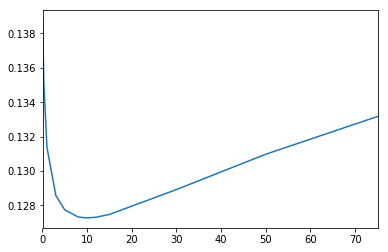

In [42]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 8, 10, 12, 15, 30, 50, 75]
ridges = [rmse_crossval(Ridge(alpha = alpha)).mean() for alpha in alphas]

pd.Series(ridges, index = alphas).plot()

In [33]:
lalphas = [1, 0.1, 0.001, 0.0005]
lasso_model = LassoCV(alphas = lalphas).fit(train_data, train_vals)

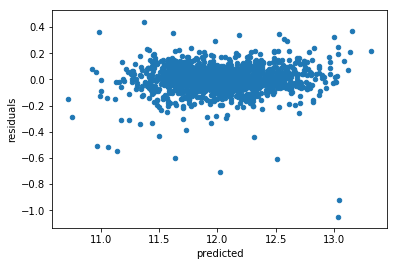

In [40]:
ridge_model = Ridge(alpha = 10)
predicted_vals = ridge_model.fit(train_data, train_vals).predict(train_data)
pd.DataFrame({"predicted": predicted_vals,
              "residuals": train_vals - predicted_vals}).plot(x="predicted", y="residuals", kind="scatter")


In [35]:
rmse_crossval(lasso_model).mean()

0.1231486904076569

In [19]:
coef = pd.Series(lasso_model.coef_, index = train_data.columns)

In [20]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 112 variables and eliminated the other 191 variables


<IPython.core.display.Javascript object>


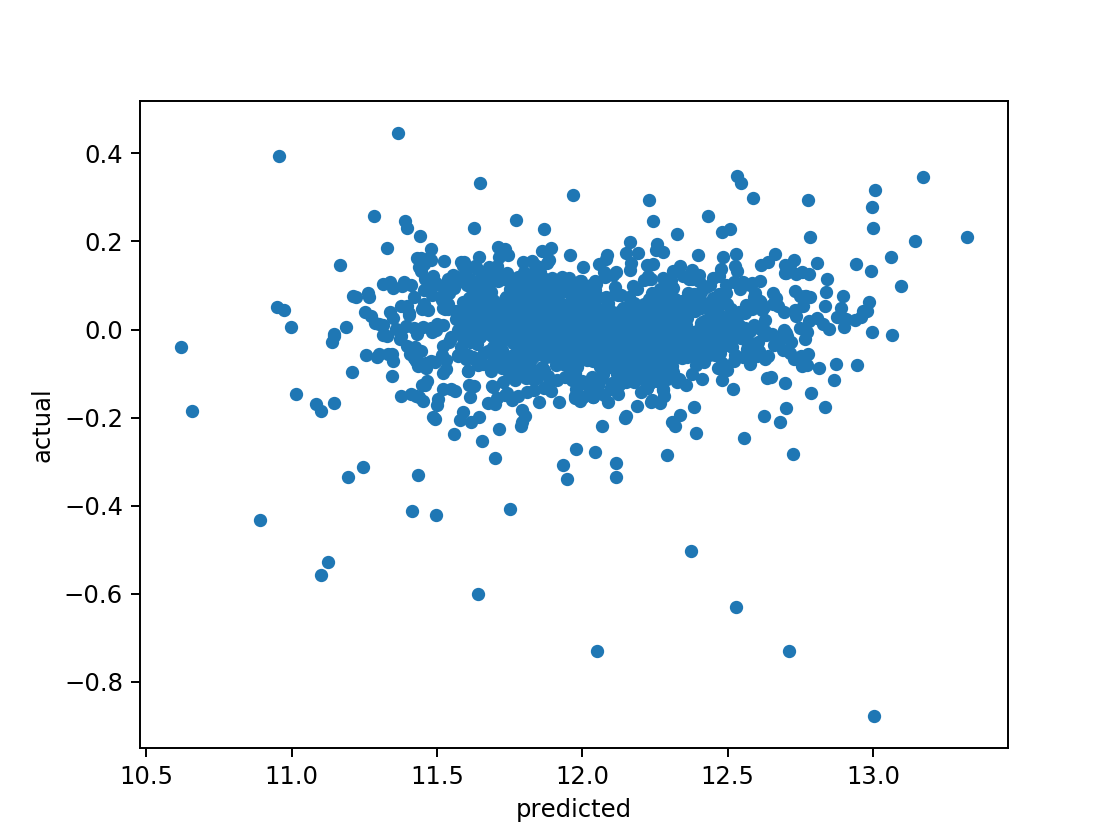

In [21]:
pd.DataFrame({"predicted": lasso_model.predict(train_data),
              "actual": train_vals - lasso_model.predict(train_data)}).plot(x="predicted", y="actual", kind="scatter")

In [22]:
from sklearn.svm import SVR

In [23]:
svr_model = SVR()

In [24]:
svr_model.fit(train_data, train_vals).predict(train_data)

array([ 12.14795836,  12.02866455,  12.21704937, ...,  12.39362604,
        11.96470454,  12.00134052])

<IPython.core.display.Javascript object>


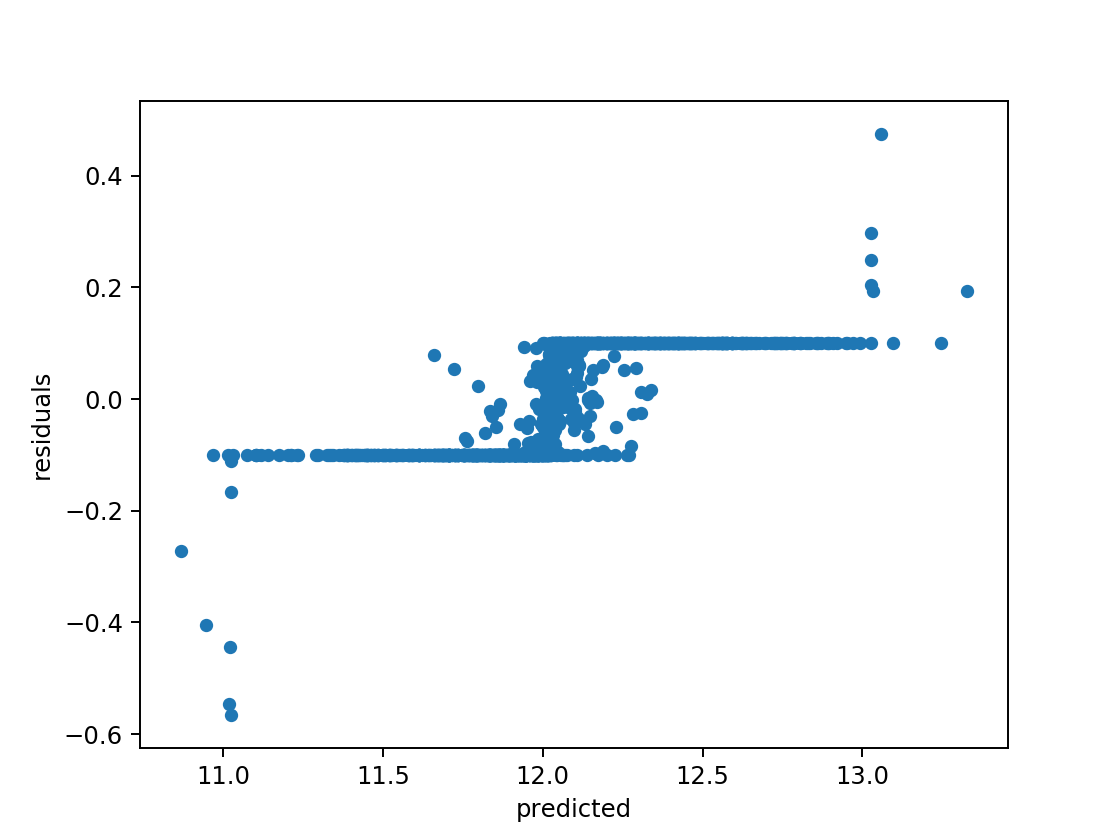

In [25]:
svr_predictions = svr_model.fit(train_data, train_vals).predict(train_data)

pd.DataFrame({"predicted": svr_predictions,
              "residuals": train_vals - svr_predictions}).plot(x="predicted", y="residuals", kind="scatter")

In [26]:
rmse_crossval(svr_model)

array([ 0.38611901,  0.42457791,  0.40948306,  0.38266032,  0.39107575])